## Resultados obtidos usando Machine Learning na Premier League

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from trinta_testes_validacao_cruzada import TrintaTestes
from graph_compare import diagram
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
#pd.options.display.float_format = '{:,.2f}'.format

## Funções para plotagem da matriz de confusão e dos atributos mais importantes

In [2]:
# Funções para plotagem da matriz de confusão

def view_confusion_matrix(conf_matrix, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix).astype('float')
    misclass = 1 - accuracy
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if classes:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

def plotConfusionMatrix(cnf_matrix, classes_):
    np.set_printoptions(precision=2)

    # para habilitar configuração de tamanho da imagem a ser plotada 
    #matplotlib.style.use('default')
    
    # tamanho da imagem a ser plotada
    #plt.figure(figsize=(6,4))
        
    # Plot non-normalized confusion matrix
    if classes_:
        view_confusion_matrix(cnf_matrix, classes=classes_,
                      title='Confusion matrix, without normalization')
    else:
        view_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
    
    # tamanho da imagem a ser plotada
    #plt.figure(figsize=(6,4))
    
    # Plot normalized confusion matrix
    if classes_:
        view_confusion_matrix(cnf_matrix, classes=classes_, normalize=True,
                      title='Normalized confusion matrix')
    else:
        view_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')
        

# função para verificação dos atributos mais importante para árvore de decisão e random forest

def importance(importancias):

    # se tiver mudado o tamanho das plotagens, posso voltar ao padrão com o comando abaixo
    #%matplotlib inline
    
    # juntando os dataframes pertencentes à lista passada como parâmetro em um só dataframe
    importances = pd.concat(importancias, axis=0, join='inner')
    
    # eliminando duplicidade de atributos e unificando por média
    importances = importances.groupby(importances.index).agg('mean')
    
    # ordenando por importância
    importances = importances.sort_values('importance', ascending = False)
    #importances = importances.iloc[0:4,:]
    display(importances)

    # imprimindo valores com nome dos atributos, em ordem e através de gráfico em barras
    importances.plot(kind='bar')

## Separação da base em previsores e classe

In [3]:
#base = pd.read_csv('dados_meio_tempo_com_odds.csv').drop(['Unnamed: 0'], axis=1).sample(frac=1).reset_index(drop=True)
base = pd.read_csv('dados_meio_tempo_com_odds_sem_vencedor_e_gols_ht.csv').drop(['Unnamed: 0'], axis=1).sample(frac=1).reset_index(drop=True)
#base = pd.read_csv('dados_meio_tempo_sem_odds_sem_vencedor_e_gols_ht.csv').drop(['Unnamed: 0'], axis=1).sample(frac=1).reset_index(drop=True)

previsores = base.iloc[:, 0:-1].values #returns a numpy array
classe = base.iloc[:, -1].values

classes_alvo = ['Visitante', 'Empate', 'Mandante']

# apenas para visualizar em forma de dataframe
classe_df = pd.DataFrame(classe)
previsores_df = pd.DataFrame(previsores)

## Pré-processamento dos dados

In [4]:
# transformando variáveis categóricas em numéricas usando o LabelEncoder

# para previsores
labelencoder_X = LabelEncoder()
previsores[:, 0] = labelencoder_X.fit_transform(previsores[:, 0])
previsores[:, 1] = labelencoder_X.fit_transform(previsores[:, 1])

# usar LabelEncoder na posição 31 apenas se essa posiçã tiver a coluna "vencedorht"
try:
    if base.iloc[:, 31:32].columns[0] == 'vencedorht':
        previsores[:, 31] = labelencoder_X.fit_transform(previsores[:, 31])
except:
    pass

# para classe LabelEncoder não costuma ser necessário
'''labelencoder_classe = LabelEncoder()
classe = labelencoder_classe.fit_transform(classe)'''

pass

# apenas para visualizar em forma de dataframe
previsores_le_df = pd.DataFrame(previsores) 

In [ ]:
# transformando variáveis categóricas em numéricas e tirando o peso dos valores após a transformação
# através do OneHotEncoder

try:
    if base.iloc[:, 31:32].columns[0] == 'vencedorht':
            column_tranformer = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [0, 1, 31])],remainder='passthrough')
    else:
        column_tranformer = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [0, 1])],remainder='passthrough')
except:
        column_tranformer = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [0, 1])],remainder='passthrough')

previsores = column_tranformer.fit_transform(previsores)

# apenas para visualizar em forma de dataframe
previsores_ohe_df = pd.DataFrame(previsores)

In [5]:
# fazendo padronização das variáveis através do StandardScaler

scaler = StandardScaler()
previsores = scaler.fit_transform(previsores)

# apenas para visualizar em forma de dataframe
previsores_ss_df = pd.DataFrame(previsores)

In [ ]:
# fazendo padronização com o StandardScaler sem afetar as odds

scaler = StandardScaler()
prev_parciais = pd.DataFrame(scaler.fit_transform(previsores))

prev_parciais.drop(prev_parciais.iloc[:,-3:], axis=1, inplace=True)
previsores = pd.DataFrame(previsores)
previsores.drop(previsores.iloc[:,0:-3], axis=1, inplace=True)
previsores = pd.concat([prev_parciais, previsores], axis=1, join='inner')
previsores = previsores.to_numpy()

# apenas para visualizar em forma de dataframe
previsores_sso_df = pd.DataFrame(previsores)

In [ ]:
# Normalização dos dados com o preprocessing.MinMaxScaler

min_max_scaler = preprocessing.MinMaxScaler()
previsores = min_max_scaler.fit_transform(previsores)

# apenas para visualizar em forma de dataframe
previsores_n_df = pd.DataFrame(previsores)

In [ ]:
# Normalização dos dados com o preprocessing.MinMaxScaler sem afetar as odds

min_max_scaler = preprocessing.MinMaxScaler()
prev_parciais = pd.DataFrame(min_max_scaler.fit_transform(previsores))

prev_parciais.drop(prev_parciais.iloc[:,-3:], axis=1, inplace=True)
previsores = pd.DataFrame(previsores)
previsores.drop(previsores.iloc[:,0:-3],axis=1,inplace=True)
previsores = pd.concat([prev_parciais, previsores], axis=1, join='inner')
previsores = previsores.to_numpy()

# apenas para visualizar em forma de dataframe
previsores_no_df = pd.DataFrame(previsores)

## Fazendo chamada para os algoritmos de Machine Learning

In [ ]:
# chamando método para fazer treinamento e classificação com trinta testes
# e validação cruzada usando StratifiedKFold
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

columns_ = None

if ( len(pd.DataFrame(previsores).columns) <= 36):
    num_cols = len(pd.DataFrame(previsores).columns)
    columns_ = base.iloc[:, 0:num_cols].columns

classificador = DecisionTreeClassifier()
decision_tree = TrintaTestes(classificador, previsores, classe, columns_)

In [ ]:
print(list(decision_tree.acuracia()))

In [ ]:
print(decision_tree.acuracia().mean())

In [ ]:
# chamando método para fazer treinamento e classificação com trinta testes
# e validação cruzada usando StratifiedKFold
# Gaussian Naive Bayes

from sklearn.naive_bayes import GaussianNB

classificador = GaussianNB()
naive_bayes = TrintaTestes(classificador, previsores, classe)

In [ ]:
print(list(naive_bayes.acuracia()))

In [ ]:
print(naive_bayes.acuracia().mean())

In [ ]:
# chamando método para fazer treinamento e classificação com trinta testes
# e validação cruzada usando StratifiedKFold
# ODDS

from odds import OddsClassifier

classificador = OddsClassifier() 
odds = TrintaTestes(classificador, previsores, classe)

In [ ]:
print(list(odds.acuracia()))

In [ ]:
print(odds.acuracia().mean())

In [ ]:
# chamando método para fazer treinamento e classificação com trinta testes
# e validação cruzada usando StratifiedKFold
# KNN

from sklearn.neighbors import KNeighborsClassifier

classificador = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p = 2)
knn = TrintaTestes(classificador, previsores, classe)

In [ ]:
print(list(knn.acuracia()))

In [ ]:
print(knn.acuracia().mean())

In [ ]:
# chamando método para fazer treinamento e classificação com trinta testes
# e validação cruzada usando StratifiedKFold
# RNA

from sklearn.neural_network import MLPClassifier

classificador = MLPClassifier(verbose = True, max_iter = 1000,
                      tol = 0.000010, solver='adam',
                      hidden_layer_sizes=(100), activation = 'relu',
                      batch_size=200, learning_rate_init=0.001)
rna = TrintaTestes(classificador, previsores, classe)

In [ ]:
rna.acuracia().mean()

In [ ]:
print(list(rna.acuracia()))

In [ ]:
pd.DataFrame(previsores)

In [ ]:
# chamando método para fazer treinamento e classificação com trinta testes
# e validação cruzada usando StratifiedKFold
# SVM

from sklearn.svm import SVC

classificador = SVC(kernel = 'rbf', random_state = 1, C = 2.0)
svm = TrintaTestes(classificador, previsores, classe)

In [ ]:
print(list(svm.acuracia()))

In [ ]:
print(svm.acuracia().mean())

In [6]:
# chamando método para fazer treinamento e classificação com trinta testes
# e validação cruzada usando StratifiedKFold
# Random Forest

from sklearn.ensemble import RandomForestClassifier

columns_ = None

if ( len(pd.DataFrame(previsores).columns) <= 36):
    num_cols = len(pd.DataFrame(previsores).columns)
    columns_ = base.iloc[:, 0:num_cols].columns
    
classificador = RandomForestClassifier(n_estimators=40, criterion='entropy', random_state=0)
random_forest = TrintaTestes(classificador, previsores, classe, columns_)

In [7]:
print(random_forest.acuracia().mean())

0.5792575810386894


In [ ]:
print(list(random_forest.acuracia()))

### Base sem vencedor nem gols ht

In [ ]:
# base sem vencedorht, golscasaht, golsvisitanteht > LabelEncoder > StandardScaler
# acurácia = 0.5790

random_forest_list = [0.574607877309167, 0.5786336702683862, 0.572037295224817, 0.5673274660160335, 0.5785683164865807, 0.5779147786685256, 0.5720067967933078, 0.5739979086789823, 0.5872037295224817, 0.5885369466713141, 0.573980481003834, 0.5898745207389334, 0.5799189613105612, 0.5679766469153015, 0.5852561868246775, 0.568686824677588, 0.5798884628790519, 0.5687434646218195, 0.5805812129661903, 0.5865284071104915, 0.5844893691181596, 0.5713750435691878, 0.5805899268037644, 0.5892035552457302, 0.5858922969675845, 0.587892122690833, 0.5885630881840362, 0.57397176716626, 0.5773004531195538, 0.5785683164865807]

### Base sem vencedor e gols ht nem odds

In [ ]:
# base sem vencedorht, golscasaht, golsvisitanteht, odds > LabelEncoder > StandardScaler
# acurácia = 0.5682

random_forest_list = [0.5614020564656675, 0.5654409201812478, 0.5554722899965145, 0.5686519693272917, 0.572695189961659, 0.5641207737887766, 0.5686040432206344, 0.5548710352039038, 0.5654365632624608, 0.5673405367723945, 0.5627396305332868, 0.5654234925060997, 0.567397176716626, 0.5660378180550715, 0.5752875566399442, 0.56341059602649, 0.5719545137678634, 0.572669048448937, 0.570616939700244, 0.5647176716626002, 0.5759759498082956, 0.5614064133844545, 0.5640641338445451, 0.5686955385151621, 0.5707389334262809, 0.5745991634715929, 0.5779017079121644, 0.5812652492157546, 0.5739325548971766, 0.5739325548971766]

### Atributos mais Importantes em números e gráfico de barras

In [18]:
len(random_forest.importances())

300

,importance
PSA,0.066491
PSH,0.066134
passesvisitanteht,0.050111
PSD,0.049948
passescasaht,0.040724
chutesnogolcasaht,0.039862
duelosganhosvisitanteht,0.033713
possebolavisitanteht,0.033619
passescertosvisitanteht,0.033503
possebolacasaht,0.033136


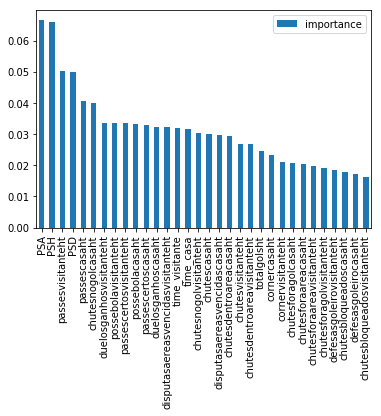

In [8]:
importance(random_forest.importances())

### Preparando para exibir em Boxplot

In [19]:
atributos_importantes = pd.concat(random_forest.importances(), axis=0, join='inner')

In [20]:
atributos_importantes['feature'] = atributos_importantes.index
atributos_importantes = atributos_importantes[['feature', 'importance']]
atributos_importantes = atributos_importantes.reset_index(drop=True)

In [21]:
atributos_importantes_list = atributos_importantes.groupby('feature')['importance'].apply(list)

In [22]:
col = atributos_importantes_list.index

In [23]:
df_list = []
for i in range(len(col)):
    df_list.append(pd.DataFrame(atributos_importantes_list[i], columns=[col[i]]))
caracteristica_final_df = pd.concat(df_list, axis=1, join='inner')

In [24]:
col_caracteristicas = caracteristica_final_df.mean().sort_values().index

In [25]:
col_caracteristicas = list(col_caracteristicas)

## Boxplot com os Atributos mais Importantes

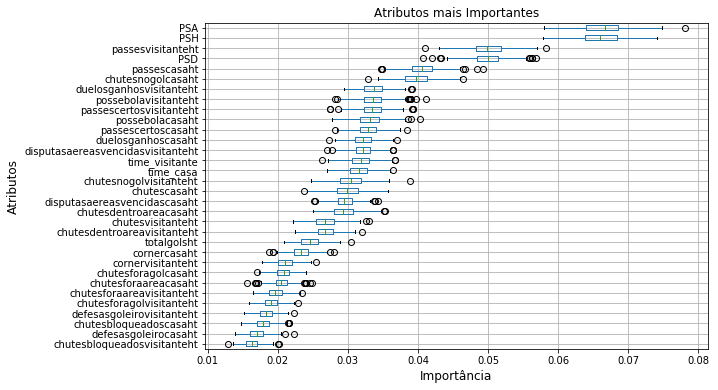

In [26]:
# Pré-processamento usado para o Random Forest => LabelEncoder e StandardScaler
# Pré-processamento usado para a Árvore de Decisão => LabelEncoder e Normalização

fig = plt.figure(figsize=(9,6))
caracteristica_final_df.boxplot(column=col_caracteristicas, vert=False)
plt.title('Atributos mais Importantes')
plt.xlabel('Importância', fontsize=12, color='black')
plt.ylabel('Atributos', fontsize=12, color='black')

# para rotacionar os nomes dos atributos no boxplot em x, para o eixo y é só substituir x por y em plt.xticks
#plt.xticks(rotation=90)

plt.show()

## Lista com os resultados de cada algoritmo
### Para os valores abaixo a base usada contém todos os atributos

In [ ]:
# Lista com os resultados dos algoritmos para o boxplot - trazida por chamada feita anteriormente
# para não ter que executar todo o código sempre

svm_list = [0.6518952596723597, 0.6565005228302544, 0.6571976298361799, 0.6558208434994771, 0.6531849076333217, 0.6571453468107354, 0.6552021610317184, 0.6538297316138026, 0.6545094109445799, 0.6552283025444405, 0.6571497037295224, 0.6578337399790868, 0.6531456953642384, 0.6544876263506448, 0.6519126873475078, 0.6558644126873474, 0.6578293830602997, 0.6519126873475078, 0.6558644126873474, 0.6512417218543046, 0.6585700592540955, 0.655154234925061, 0.6538820146392471, 0.6578729522481701, 0.651930115022656, 0.6585439177413732, 0.6579470198675497, 0.6597464273265946, 0.6565135935866155, 0.6552195887068665]
random_forest_list = [0.6373387940048797, 0.6352605437434646, 0.6426368072499129, 0.6441007319623562, 0.6399747298710352, 0.6374085047054723, 0.641368943882886, 0.6419919832694319, 0.6499346462181945, 0.6387504356918787, 0.6413253746950157, 0.6440135935866156, 0.6486057859881492, 0.6354261066573719, 0.6361101429069362, 0.634803067270826, 0.6380228302544441, 0.6432685604740327, 0.6401228651097943, 0.6413340885325898, 0.6439961659114675, 0.6413515162077379, 0.6379923318229348, 0.6367549668874173, 0.6394388288602301, 0.6519039735099338, 0.6618290345067968, 0.626158940397351, 0.6387678633670268, 0.6387373649355176]
knn_list = [0.619588706866504, 0.617536598117811, 0.6056509236667829, 0.6017471244336006, 0.612247298710352, 0.6155803415824328, 0.6070233530846985, 0.6017166260020913, 0.61095765074939, 0.6103128267689091, 0.6063828860230045, 0.6129531195538516, 0.603733879400488, 0.605668351341931, 0.6103041129313349, 0.6036685256186824, 0.6136589403973509, 0.6063349599163471, 0.6103389682816311, 0.6083522133147439, 0.6183382711746253, 0.6103215406064831, 0.6083870686650401, 0.6070015684907634, 0.6142384105960266, 0.603733879400488, 0.6063262460787731, 0.6089752527012896, 0.5964491111885675, 0.6136894388288602]
naive_bayes_list = [0.5951333217148832, 0.600387765772046, 0.5971331474381317, 0.6010238759149529, 0.5997168002788428, 0.5944972115719762, 0.5990414778668526, 0.5911728825374695, 0.5977256883931683, 0.5984140815615197, 0.6003180550714535, 0.5951551063088184, 0.6011023004531195, 0.5965057511327989, 0.59908940397351, 0.5971331474381317, 0.591111885674451, 0.5917915650052283, 0.593808818403625, 0.596523178807947, 0.5944187870338097, 0.6023265946322761, 0.6018299058905542, 0.5977518299058906, 0.6017296967584524, 0.5937173231090973, 0.5963750435691879, 0.5951507493900314, 0.5971200766817707, 0.5904714186127571]
odds_list = [0.5541042174973858, 0.5542305681422098, 0.5542436388985709, 0.5542392819797839, 0.5541913558731265, 0.554139072847682, 0.5541608574416174, 0.5542349250609969, 0.5541565005228303, 0.5541913558731265, 0.5541913558731265, 0.5541565005228303, 0.5541477866852562, 0.5541521436040433, 0.5542131404670617, 0.5542218543046358, 0.5541826420355525, 0.5541434297664691, 0.5541477866852562, 0.5541477866852562, 0.5541913558731265, 0.554139072847682, 0.5542044266294877, 0.5541695712791913, 0.5541695712791913, 0.5541695712791913, 0.554117288253747, 0.5541608574416172, 0.5541477866852562, 0.5542174973858487]
decision_tree_list = [0.5646915301498779, 0.5277884280237016, 0.5469283722551411, 0.5370120250958522, 0.5455472289996515, 0.5330254444057163, 0.5489194841408156, 0.5443185779017079, 0.5422621122342279, 0.5442445102823283, 0.5475426978041129, 0.5495163820146393, 0.5363149180899268, 0.5449329034506797, 0.5362844196584176, 0.5382450331125828, 0.5409855350296271, 0.5449198326943185, 0.5528929940745904, 0.5535378180550714, 0.5310212617636807, 0.5389334262809341, 0.5423187521784594, 0.5356352387591495, 0.5125261415127221, 0.55810822586267, 0.5245120250958523, 0.5317532241199024, 0.5560822586266992, 0.511210352039038]
rna_list = [0.5990806901359359, 0.6043612757058209, 0.6194841408156152, 0.6136371558034158, 0.6189046706169397, 0.6122298710352039, 0.6209132101777624, 0.62682119205298, 0.6241983269431858, 0.6340318926455211, 0.6228389682816312, 0.6314874520738933, 0.6274660160334611, 0.6208870686650401, 0.6103215406064831, 0.6235578598814918, 0.6194710700592541, 0.6149224468455908, 0.6130097594980829, 0.6189177413733008, 0.6307816312303938, 0.6148963053328685, 0.6148701638201464, 0.6175845242244684, 0.6222289996514465, 0.6194841408156152, 0.6214752527012897, 0.6294963401882189, 0.621523178807947, 0.6003572673405368]

### Para os valores abaixo a base usada não contém vencedorht nem gols casa e visitante ht

### Pré-processamento usado para cada algoritmo

In [27]:
indices = ['RNA', 'SVM', 'Random Forest', 'Naive Bayes', 'KNN', 'Árvore de Decisão']
pp = pd.DataFrame({'LabelEncoder e StandardScaler':['','','\u2713','','',''], 
                   'LabelEncoder e StandardScaler sem afetar as odds':['','\u2713','','\u2713','\u2713',''], 
                   'LabelEncoder e Normalização sem afetar as odds':['\u2713','','','','',''], 
                   'LabelEncoder e Normalização':['','','','','','\u2713']}, index = indices)
pp

,LabelEncoder e StandardScaler,LabelEncoder e StandardScaler sem afetar as odds,LabelEncoder e Normalização sem afetar as odds,LabelEncoder e Normalização
RNA,,,✓,
SVM,,✓,,
Random Forest,✓,,,
Naive Bayes,,✓,,
KNN,,✓,,
Árvore de Decisão,,,,✓


In [28]:
svm_list = [0.6043351341930986, 0.59845765074939, 0.6089970372952248, 0.5978084698501219, 0.5970939351690484, 0.5990937608922969, 0.5937303938654583, 0.6070625653537818, 0.6023745207389334, 0.6030324154757756, 0.5997777971418613, 0.6030106308818404, 0.5990632624607877, 0.5917392819797839, 0.5977736144998257, 0.5917305681422098, 0.5977692575810387, 0.5983835831300104, 0.6050148135238759, 0.6044397002439874, 0.6083434994771697, 0.5970547228999651, 0.603102126176368, 0.605040955036598, 0.593821889159986, 0.6083130010456606, 0.5957432903450679, 0.5957737887765772, 0.6030106308818404, 0.6043351341930986]
random_forest_list = [0.5806073544789125, 0.5799799581735796, 0.562107877309167, 0.5825766817706518, 0.5898919484140815, 0.5865284071104915, 0.5865763332171487, 0.5865284071104915, 0.5897743116068317, 0.5891469153014988, 0.5779234925060998, 0.5679722899965144, 0.5898440223074242, 0.573318229348205, 0.5786467410247473, 0.5838706866504009, 0.5812652492157546, 0.5746819449285465, 0.5759890205646567, 0.5878267689090275, 0.5660596026490066, 0.578611885674451, 0.5785247472987104, 0.5858966538863716, 0.5812957476472638, 0.5825853956082259, 0.5785508888114326, 0.581949285465319, 0.5739456256535378, 0.582589752527013]
knn_list = [0.5092410247472987, 0.5192357964447543, 0.5205298013245032, 0.5297141861275706, 0.516486580690136, 0.5204165214360404, 0.5184646218194493, 0.5211266991983269, 0.5264116416869989, 0.5191268734750785, 0.516490937608923, 0.5197586266991984, 0.5164691530149879, 0.505929766469153, 0.5238105611711397, 0.5152448588358313, 0.5138637155803416, 0.5290606483095155, 0.521139769954688, 0.5131273963053329, 0.515210003485535, 0.5238584872777972, 0.5197455559428372, 0.5098466364586964, 0.5132101777622865, 0.5125827814569537, 0.5152056465667479, 0.5324154757755315, 0.5171357615894039, 0.5264377831997212]
naive_bayes_list = [0.5231047403276403, 0.525135064482398, 0.5238062042523527, 0.5217933077727431, 0.5211049146043918, 0.5224337748344371, 0.5164952945277099, 0.5204862321366329, 0.5204252352736145, 0.523065528058557, 0.5238802718717324, 0.5231178110840015, 0.5211789822237713, 0.5230916695712792, 0.5211833391425584, 0.5224468455907981, 0.5198021958870687, 0.5185038340885326, 0.5211833391425584, 0.5211702683861973, 0.5198109097246427, 0.5231439525967236, 0.5178023701638201, 0.5244336005576856, 0.5217497385848728, 0.5224381317532242, 0.5237016382014639, 0.5184820494945974, 0.5158417567096549, 0.521131056117114]
odds_list = [0.554117288253747, 0.554139072847682, 0.5541652143604043, 0.5541565005228303, 0.554117288253747, 0.5542087835482746, 0.5541826420355525, 0.5542697804112932, 0.5541565005228303, 0.5541042174973858, 0.5542305681422098, 0.5542218543046358, 0.5542741373300801, 0.5541782851167654, 0.5542087835482746, 0.5541913558731265, 0.554126002091321, 0.5541695712791913, 0.5541957127919136, 0.554126002091321, 0.5542044266294877, 0.5541739281979784, 0.5542000697107006, 0.5541608574416174, 0.5541826420355525, 0.5541434297664691, 0.5541565005228303, 0.5540911467410248, 0.5541477866852562, 0.5541652143604043]
decision_tree_list = [0.4689133844545138, 0.48278145695364233, 0.47617636807249913, 0.49671924015336355, 0.46898745207389336, 0.47883844545137677, 0.4894475426978041, 0.48210177762286505, 0.47560996863018473, 0.4834742070407808, 0.4920878354827466, 0.4722159288950854, 0.49604391774137324, 0.4768691181596375, 0.4874041477866853, 0.4933731265249216, 0.49005751132798886, 0.4947804112931335, 0.4775487974904148, 0.4802283025444406, 0.49800453119553845, 0.4814874520738933, 0.4887547926106658, 0.47493464621819453, 0.4986624259323806, 0.4643691181596375, 0.4769126873475079, 0.4768996165911467, 0.5026577204600906, 0.4756273963053329]
rna_list = [0.6242026838619729, 0.6215580341582433, 0.6069884977344022, 0.6176280934123388, 0.606966713140467, 0.6044179156500522, 0.6083522133147439, 0.6076725339839666, 0.6116242593238062, 0.6168569187870337, 0.6004226211223422, 0.6175278842802371, 0.608373997908679, 0.6050104566050889, 0.6103520390379924, 0.6069405716277448, 0.5984010108051586, 0.6221897873823632, 0.6135761589403973, 0.6248954339491112, 0.6188959567793656, 0.6227866852561867, 0.6122995817357963, 0.616233879400488, 0.6148919484140816, 0.5970590798187522, 0.6195625653537818, 0.6070625653537818, 0.626795050540258, 0.6288689438828861]

### Chamando os resultados e armazenando em lista

In [ ]:
# Trazendo por chamada a lista com os resultados dos algoritmos para o boxplot

random_forest_list = random_forest.acuracia()
odds_list = odds.acuracia()
svm_list = svm.acuracia()
knn_list = knn.acuracia()
naive_bayes_list = naive_bayes.acuracia()
decision_tree_list = decision_tree.acuracia()
rna_list = rna.acuracia()

### Juntando todas as listas de resultados em um único dataframe para exibir

In [29]:
# Dando nome às colunas dos algoritmos
random_forest_df = pd.DataFrame(random_forest_list, columns=['Random Forest'])
svm_df = pd.DataFrame(svm_list, columns=['SVM'])
knn_df = pd.DataFrame(knn_list, columns=['KNN'])
naive_bayes_df = pd.DataFrame(naive_bayes_list, columns=['Naive Bayes'])
odds_df = pd.DataFrame(odds_list, columns=['ODDS'])
rna_df = pd.DataFrame(rna_list, columns=['RNA'])
# também pode ser assim
decision_tree_df = pd.DataFrame(decision_tree_list).rename(columns={0:'Árvore de Decisão'})

# juntando todos os dataframes acima em um só 
resultados_df = pd.concat([random_forest_df,svm_df,knn_df,
                           naive_bayes_df,odds_df,rna_df,decision_tree_df], axis=1, join='inner')

#display(resultados_df)

## Exibindo o resultado após trinta testes  usando o StratifiedKFold

,resultado
RNA,0.613280
SVM,0.600508
Random Forest,0.580502
ODDS,0.554172
Naive Bayes,0.521398
KNN,0.518710
Árvore de Decisão,0.483399


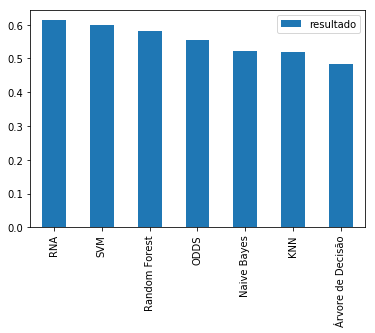

In [30]:
modelos_list = [random_forest_df.mean(), svm_df.mean(), knn_df.mean(),
                naive_bayes_df.mean(), odds_df.mean(), rna_df.mean(), decision_tree_df.mean()]

modelos_df = pd.concat(modelos_list, axis=0, join='inner')
modelos_df = pd.DataFrame(modelos_df, columns=['resultado'])
# ordenando por importância
modelos_df = modelos_df.sort_values('resultado', ascending = False)

display(modelos_df)

# imprimindo valores com nome dos atributos, em ordem e através de gráfico em barras
modelos_df.plot(kind='bar')

## Boxplot com os resultados

In [31]:
col_resultados = resultados_df.mean().sort_values(ascending = False).index

In [32]:
col_resultados = list(col_resultados)

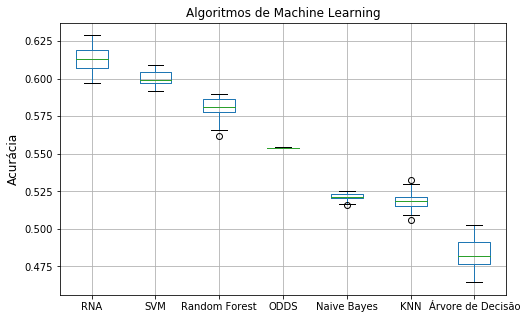

In [33]:
fig = plt.figure(figsize=(8,5))
resultados_df.boxplot(column=col_resultados)
plt.title('Algoritmos de Machine Learning')
plt.ylabel('Acurácia', fontsize=12, color='black')
plt.show()